In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_nodeinfo.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_nodeinfotest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.543895,0.008625,924.236712,63156.175327,0.176144,2128.447148,10523.371640,1.0,50.0,0.103940,6.0,44.260521,1.240458e+10,36.548910
1,0.555150,0.011289,12651.807738,94205.906535,0.176144,6182.507055,20512.544166,1.0,192.0,0.108720,6.0,44.260521,1.240458e+10,37.249118
2,0.521781,0.010222,12652.088889,107315.200000,0.196314,7243.755556,20228.244444,1.0,333.0,0.105527,6.0,15.116667,1.240458e+10,37.249118
3,0.521781,0.009778,11832.888889,115234.133333,0.196314,8994.822222,25560.088889,1.0,474.0,0.108370,6.0,15.116667,1.240458e+10,37.201915
4,0.406110,0.008533,0.000000,97939.911111,0.196123,7063.244444,18804.822222,1.0,564.0,0.103987,6.0,10.733333,1.240458e+10,37.201915


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.779273,453.373747,0.103940,50.0
1,1.779273,462.059520,0.108720,192.0
2,0.607690,462.059520,0.105527,333.0
3,0.607690,461.473997,0.108370,474.0
4,0.431480,461.473997,0.103987,564.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
3259,2.320906,719.402803,1.066886,32851.0
3260,2.320906,719.402803,1.066886,33354.0
3261,2.283962,720.458957,1.590062,25033.0
3262,2.283962,720.458957,1.066886,15677.0
3263,2.481944,721.086874,1.066886,9044.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(2727, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

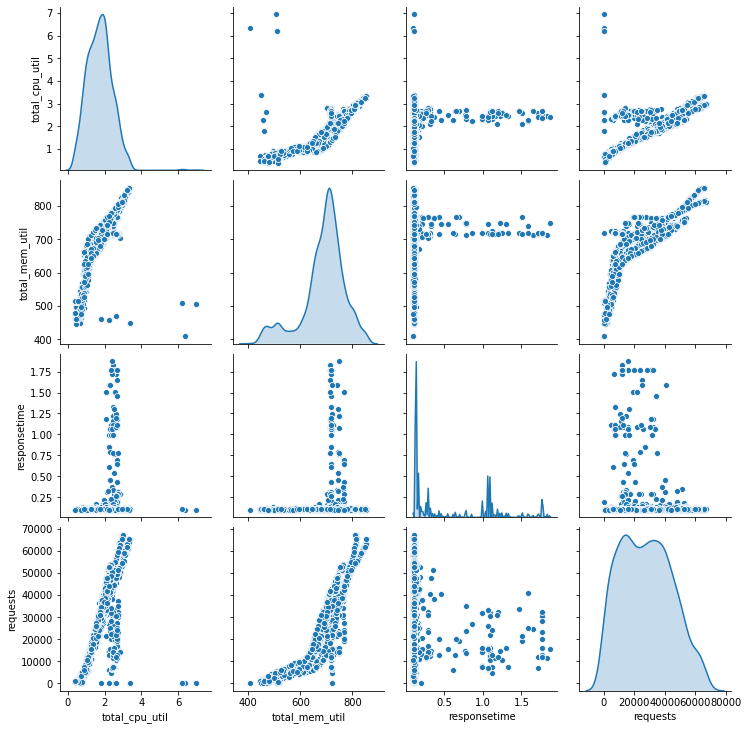

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,2182.0,1.741866,0.673673,0.377210,1.247763,1.745797,2.147127,6.944027
total_mem_util,2182.0,690.304782,81.228205,408.856781,658.080154,703.876612,737.896397,854.741000
responsetime,2182.0,0.148404,0.210252,0.098689,0.103122,0.106016,0.110243,1.873295
requests,2182.0,27882.664070,16793.101335,1.000000,13868.750000,27295.500000,40592.500000,67293.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
3247,2.408301,719.560704,1.066886,6570.0
332,2.113220,714.464256,0.105614,41185.0
195,1.594823,668.969779,0.104269,26223.0
2650,1.812350,724.275610,0.117942,35456.0
1436,0.444657,513.078072,0.107781,547.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
normalizer = preprocessing.Normalization()

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[  1.742 690.305   0.148]


## Linear Regression

In [18]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [19]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [20]:
model.predict(test_features)

array([[-0.438],
       [ 0.611],
       [-0.728],
       [-0.714],
       [-0.771],
       [-0.775],
       [-0.771],
       [-0.797],
       [-0.805],
       [-0.804],
       [-0.803],
       [-0.804],
       [-0.805],
       [-0.805],
       [-0.747],
       [-0.695],
       [-0.678],
       [-0.641],
       [-0.676],
       [-0.668],
       [-0.664],
       [-0.632],
       [-0.609],
       [-0.562],
       [-0.559],
       [-0.503],
       [-0.526],
       [-0.508],
       [-0.502],
       [-0.446],
       [-0.436],
       [-0.399],
       [-0.371],
       [-0.348],
       [-0.333],
       [-0.334],
       [-0.329],
       [-0.284],
       [-0.262],
       [-0.215],
       [-0.224],
       [-0.178],
       [-0.166],
       [-0.139],
       [-0.139],
       [-0.099],
       [-0.113],
       [-0.082],
       [-0.106],
       [-0.095],
       [-0.089],
       [-0.094],
       [-0.084],
       [-0.075],
       [-0.056],
       [-0.062],
       [-0.071],
       [-0.051],
       [-0.062

In [21]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [22]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 7.7 s, sys: 1.16 s, total: 8.86 s
Wall time: 5.86 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,27059.050781,28573.941406,95
96,27053.681641,28568.441406,96
97,27048.281250,28562.970703,97
98,27042.906250,28557.476562,98
99,27037.505859,28552.041016,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 30000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

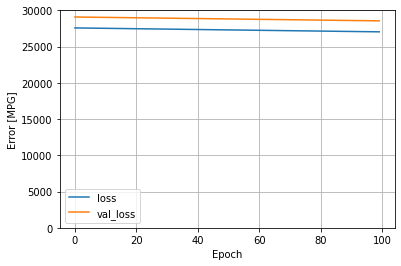

In [25]:
plot_loss(history)

In [26]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [28]:
dnn_model = build_and_compile_model(input_normalizer)

In [29]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [30]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=3000)

CPU times: user 5min 38s, sys: 56.6 s, total: 6min 34s
Wall time: 4min 8s


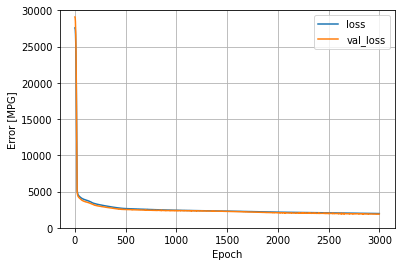

In [31]:
plot_loss(history)

In [32]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [33]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,27708.945312
dnn_model,1948.530762


## Make Predictions

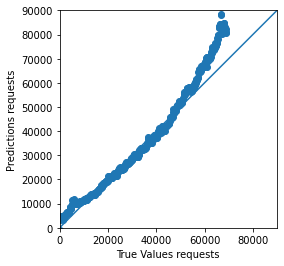

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 90000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [35]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.9342515265787931


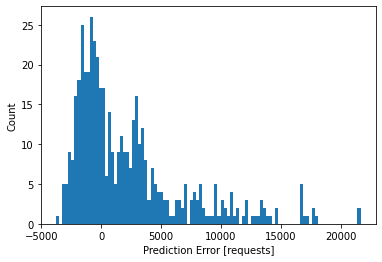

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')